# Predicting Housing Prices

Data Source: https://www.kaggle.com/anthonypino/melbourne-housing-market

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer


# setting styles for plotting
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_palette('husl')
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

print(df.shape)
df.head()

(34857, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


  ## Exploratory Analysis and Data Cleaning

In [3]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [4]:
# 1st things 1st - we're trying to predict value - can't do that with nan values for price
#dropping rows where price = nan
df = df[np.isfinite(df.Price)]
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


In [5]:
df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,27247.000000,2.724700e+04,27246.000000,27246.000000,20806.000000,20800.000000,20423.000000,17982.000000,10656.000000,12084.000000,20993.000000,20993.000000,27244.000000
mean,2.992293,1.050173e+06,11.280276,3113.796080,3.046237,1.591683,1.715370,593.488933,156.834586,1966.609153,-37.806963,144.996711,7566.781089
std,0.954795,6.414671e+05,6.787469,111.139676,0.955122,0.700880,0.994216,3757.266429,449.222791,36.762373,0.091619,0.120680,4492.382418
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3046.000000,2.000000,1.000000,1.000000,219.000000,100.000000,1950.000000,-37.860900,144.925300,4294.000000
50%,3.000000,8.700000e+05,10.500000,3088.000000,3.000000,1.000000,2.000000,512.000000,133.000000,1970.000000,-37.800460,145.003200,6567.000000
75%,4.000000,1.295000e+06,14.000000,3153.000000,4.000000,2.000000,2.000000,664.000000,182.000000,2000.000000,-37.748970,145.068770,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,20.000000,9.000000,18.000000,433014.000000,44515.000000,2019.000000,-37.397800,145.526350,21650.000000


From the max values above it looks like there are some outliers in the data.   Let's explore a little further.

In [6]:
# checking for outliers - 75% of homes have 4 rooms and the max is 16
df.loc[df['Rooms'] > 10]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12959,Hawthorn,10 Berkeley St,12,h,4700000.0,PI,Property,20/05/2017,4.6,3122.0,...,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,-37.83030,145.03670,Southern Metropolitan,11308.0
26210,Mitcham,20 Harrison St,16,h,5000000.0,S,Buxton,28/10/2017,17.2,3132.0,...,8.0,8.0,NaN,NaN,NaN,Whitehorse City Council,-37.81405,145.19891,Eastern Metropolitan,6871.0
27150,Melton,213 Station Rd,12,h,710000.0,S,PRDNationwide,11/11/2017,31.7,3337.0,...,5.0,3.0,960.0,223.0,1970.0,Melton City Council,-37.68830,144.57760,Western Victoria,3600.0


In [7]:
# car seems like it has some outliers ... 
df.loc[df['Car'] > 10]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
25839,Croydon,26 Railway Cr,2,h,1105000.0,SP,iTRAK,28/10/2017,23.0,3136.0,...,1.0,18.0,1250.0,NaN,NaN,Maroondah City Council,-37.79097,145.28695,Eastern Metropolitan,11925.0
32862,St Albans,11 Magnus St,4,h,788000.0,S,Ray,17/02/2018,14.0,3021.0,...,2.0,11.0,697.0,NaN,NaN,Brimbank City Council,-37.75612,144.80179,Western Metropolitan,14042.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 21 columns):
Suburb           27247 non-null object
Address          27247 non-null object
Rooms            27247 non-null int64
Type             27247 non-null object
Price            27247 non-null float64
Method           27247 non-null object
SellerG          27247 non-null object
Date             27247 non-null object
Distance         27246 non-null float64
Postcode         27246 non-null float64
Bedroom2         20806 non-null float64
Bathroom         20800 non-null float64
Car              20423 non-null float64
Landsize         17982 non-null float64
BuildingArea     10656 non-null float64
YearBuilt        12084 non-null float64
CouncilArea      27244 non-null object
Lattitude        20993 non-null float64
Longtitude       20993 non-null float64
Regionname       27244 non-null object
Propertycount    27244 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 4.6+ M

In [9]:
#checking for missing values

# from https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb# from  
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df).head(10)

Your selected dataframe has 21 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
BuildingArea,16591,60.9
YearBuilt,15163,55.7
Landsize,9265,34.0
Car,6824,25.0
Bathroom,6447,23.7
Bedroom2,6441,23.6
Lattitude,6254,23.0
Longtitude,6254,23.0
CouncilArea,3,0.0
Regionname,3,0.0


In [10]:
def drop_missing_values(df, percent_drop):
    """
    Drop columns with missing values.
    
    Args:
        df = dataframe
        percent_drop = percentage of null values above which the column will be dropped
            as decimal between 0 and 1
    Returns:
        df = df where columns above percent_drop are dropped.
    
    """
    to_drop = [column for column in df if (df[column].isnull().sum()/len(df) >= percent_drop)]

    print('Columns to drop: ' , (len(to_drop)))
    # Drop features 
    df = df.drop(columns=to_drop)
    print('Shape: ', df.shape)
    return df

In [11]:
#dropping columns where >60% of values missing
df = drop_missing_values(df, .6)

Columns to drop:  1
Shape:  (27247, 20)


In [12]:
# find correlations to target = price
corr_matrix = df.corr().abs()

print(corr_matrix['Price'].sort_values(ascending=False).head(20))

Price            1.000000
Rooms            0.465238
Bedroom2         0.430275
Bathroom         0.429878
YearBuilt        0.333306
Lattitude        0.215607
Distance         0.211384
Car              0.201803
Longtitude       0.197874
Propertycount    0.059017
Postcode         0.044950
Landsize         0.032748
Name: Price, dtype: float64


From the correlation matrix it looks like the most important variables that affect price are rooms, bedrooms, and year built.

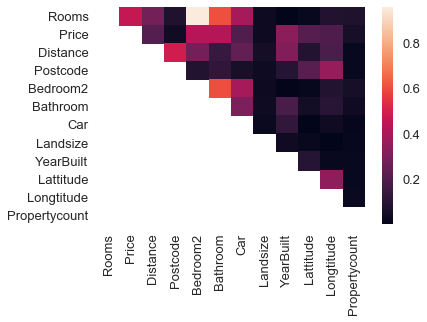

In [13]:
# Visualizing the correlation matrix
# Select upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
sns.heatmap(upper)
plt.show();

We can see here that Rooms and Bedroom2 are highly correlated.

In [14]:
#dropping highly correlated features
#code from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print('Columns to drop: ' , (len(to_drop)))

# Drop features 
df = df.drop(columns=to_drop)
print('train_features_df shape: ', df.shape)

Columns to drop:  1
train_features_df shape:  (27247, 19)


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


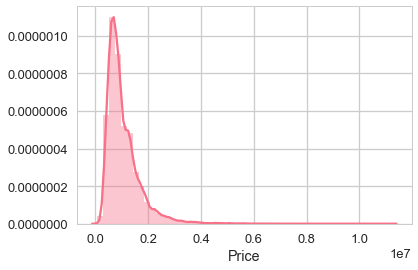

In [15]:
# plotting distribution of price ... 
# The long right tail indicates there are probably highly priced outliers
sns.distplot(df.Price);

In [16]:
#checking data types of columns
df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bathroom         float64
Car              float64
Landsize         float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

In [17]:
# checking for categorical variables
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Suburb           345
Address        26751
Type               3
Method             5
SellerG          349
Date              78
CouncilArea       33
Regionname         8
dtype: int64

In [18]:
df.shape

(27247, 19)

In [19]:
# Address has a very high percentage of unique values
# Theoretically each home has a different address
# Duplicated are being resold possibly
# But bottom line I'm assuming address won't be valuable in the model so dropping the column

df = df.drop(['Address'], 1)

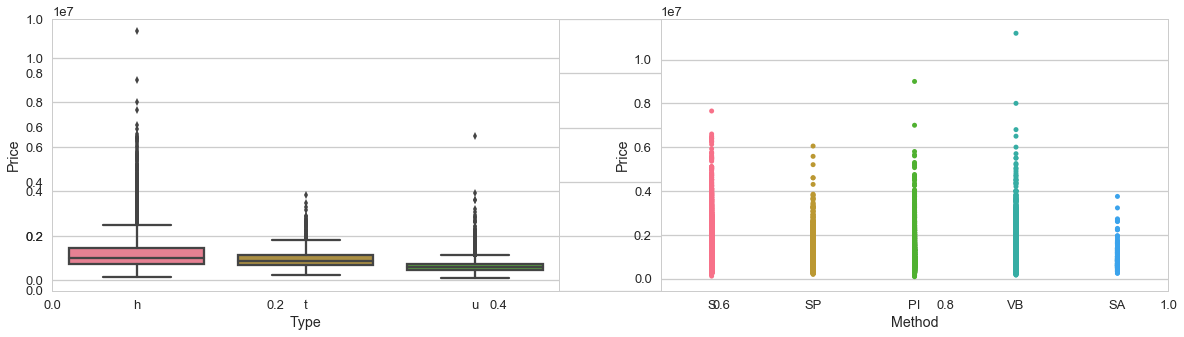

In [20]:
# visualizing some categorical variables relationship to price

plt_data = df[['Price', 'Suburb', 'Type', 'Method', 'Date', 'CouncilArea', 'Regionname']].copy()
plt_data = plt_data.dropna()

fig, ax = plt.subplots(figsize=(20,5))

fig.add_subplot(121)
sns.boxplot(x=plt_data.Type, y=plt_data.Price)

fig.add_subplot(122)
sns.stripplot(x=plt_data.Method, y=plt_data.Price)

plt.show;

These plots tell us that h type (house) is generally priced higher than t (townhouse) which is higher than u (unit), but all values have outliers.

Also SA method seems to be priced lower than other methods so it appears that method of selling has an impact on price.

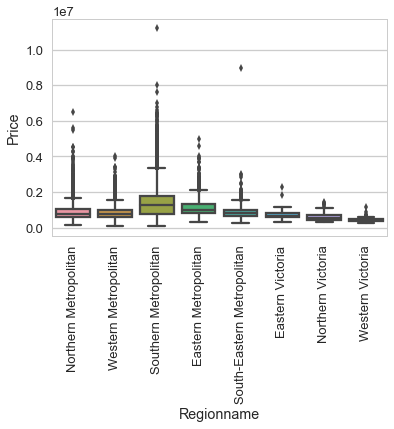

In [21]:
sns.boxplot(x=plt_data.Regionname, y=plt_data.Price)
plt.xticks(rotation=90);

From this plot we can see that a larger percentage of homes are in Southern Metropolitan and that they are generally priced higher and have the most outliers.

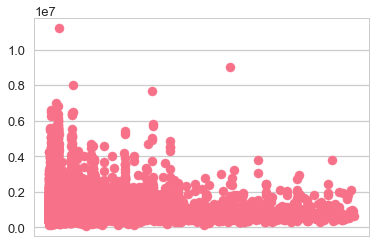

In [22]:
# I don't think the seller should have anything to do with the home price,,,
# but plotting just to be sure
fig, ax = plt.subplots()

plt.scatter(df.SellerG, df.Price)
ax.set_xticks([])
plt.show();

It looks like seller could play a role in Price, but we'll drop the column for now.

In [23]:
# dropping column SellerG
df = df.drop('SellerG', axis=1)

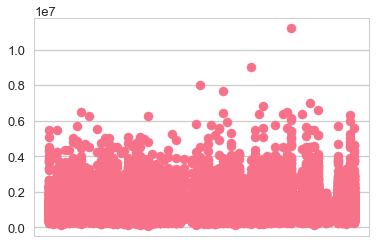

In [24]:
#Checking the Date column
fig, ax = plt.subplots()

plt.scatter(df.Date, df.Price)
ax.set_xticks([])
plt.show();

In [25]:
# Date also doesn't seem like it will be useful so dropping
df = df.drop('Date', axis=1)

In [26]:
# checking categorical variables again
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Suburb         345
Type             3
Method           5
CouncilArea     33
Regionname       8
dtype: int64

Technically we've dealt with all the categorical variables, but what about postcode?  
Since it is numeric it seems like its being classified as continuous, but really I think it should be categorical because a higher number isn't neccesarily better.

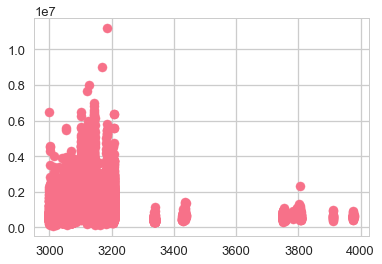

In [27]:
#plotting postcode vs price
#it definitely looks like certain postcodes are more popular and expensive
plt.scatter(df.Postcode, df.Price);

In [28]:
# converting postcode to categorical
# set up bins
# just setting up random bins by looking at the plot above
bins = [3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000,]
category = pd.cut(df.Postcode, bins)
category = category.to_frame()
df['Postcode'] = category

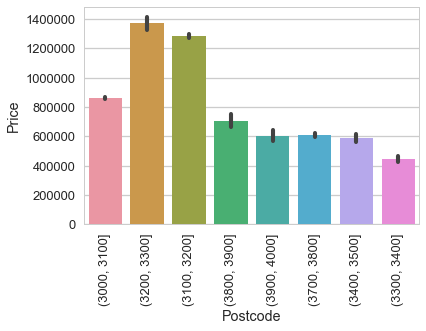

In [29]:
# and checking to make sure it worked

sns.barplot(x=df.Postcode, y=df.Price)
plt.xticks(rotation=90);

In [30]:
# one hot encoding categorical variables
df = pd.get_dummies(df)

In [31]:
# and checking to make sure it worked
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Series([], dtype: float64)

In [32]:
# Now finding the outliers - starting with the really expensive homes
df.sort_values('Price', ascending=False).head()

,Rooms,Price,Distance,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Propertycount,...,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
25635,4,11200000.0,10.5,3.0,2.0,1400.0,NaN,-37.89335,144.98643,10579.0,...,0,0,0,0,0,0,0,1,0,0
19583,3,9000000.0,18.8,1.0,1.0,744.0,1960.0,-37.93168,145.16126,7113.0,...,0,0,0,0,0,0,1,0,0,0
12539,5,8000000.0,9.0,5.0,4.0,2079.0,1880.0,-37.81790,145.06940,3265.0,...,0,0,0,0,0,0,0,1,0,0
15696,4,7650000.0,5.3,2.0,4.0,1690.0,1863.0,-37.82652,145.03052,11308.0,...,0,0,0,0,0,0,0,1,0,0
28334,4,7000000.0,6.3,NaN,NaN,NaN,NaN,NaN,NaN,4836.0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
# dropping the home with the 11 million dollar price
df = df.drop(25635)

In [34]:
# checking for really inexpensive homes
df.sort_values('Price', ascending=True).head()

,Rooms,Price,Distance,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Propertycount,...,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
4378,1,85000.0,6.4,1.0,0.0,0.0,2007.0,-37.7911,144.8900,7570.0,...,0,0,0,0,0,0,0,0,1,0
29669,1,112000.0,8.4,NaN,NaN,NaN,NaN,NaN,NaN,8801.0,...,0,0,0,0,0,0,0,1,0,0
17529,1,121000.0,1.3,NaN,NaN,NaN,NaN,NaN,NaN,3040.0,...,0,0,0,0,1,0,0,0,0,0
3063,4,131000.0,8.9,1.0,2.0,499.0,1920.0,-37.8864,145.0242,2379.0,...,0,0,0,0,0,0,0,1,0,0
11859,1,145000.0,13.9,1.0,1.0,36.0,NaN,-37.7833,144.8266,2185.0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
# dropping index 4378
#df = df.drop(4378)

In [36]:
# we need to deal with missing values before modeling
missing_values_table(df)

Your selected dataframe has 412 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
YearBuilt,15162,55.6
Landsize,9265,34.0
Car,6824,25.0
Bathroom,6447,23.7
Lattitude,6254,23.0
Longtitude,6254,23.0
Propertycount,3,0.0
Distance,1,0.0


In [37]:
# dropping YearBuilt since over 50% of values missing
df = df.drop(['YearBuilt'], 1)

## Modeling - Gradient Boosting Regression

In [38]:
# seperating our target out from the dataframe
price = df.Price
df = df.drop(['Price'], 1)

In [39]:
# imputing values for remaining null values
imputer = Imputer(strategy='mean')

imputed = imputer.fit_transform(df)

In [40]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(imputed, price, test_size=0.25, random_state=27)

In [41]:
# normalizing the data
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_train = scaler.fit_transform(X_train)

In [42]:
from sklearn import ensemble

GBR = ensemble.GradientBoostingRegressor().fit(X_train, y_train)

In [43]:
y_ = GBR.predict(X_test)
y_

array([ 625782.60158798,  327302.69712021,  685451.23694336, ...,
       1004829.89392691,  794922.73956817,  664872.43327443])

In [44]:
GBR.score(X_test, y_test)

0.7538199029024625

We get an accuracy score of 75% without tuning the model!

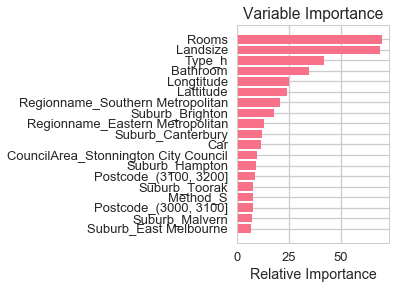

In [46]:
# checking which are the most important features
feature_importance = GBR.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Let's tune the model to see if we can improve the accuracy score.

In [47]:
GBR2 = ensemble.GradientBoostingRegressor(max_depth=5, n_estimators=500, min_samples_split=5).fit(X_train, y_train)
GBR2.score(X_test, y_test)

0.7962520912473219

In [48]:
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(y_test,y_))
print('MSE:',metrics.mean_squared_error(y_test,y_))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_)))

MAE: 191341.7269767977
MSE: 97278093807.06503
RMSE: 311894.36321784504


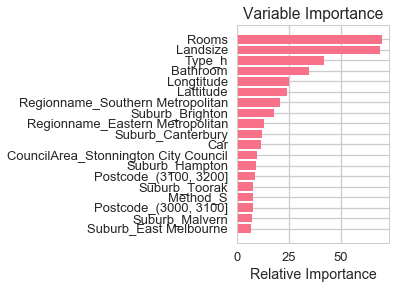

In [49]:
# checking which are the most important features
feature_importance = GBR2.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

From the variable importance plot above we can see the most important features in determining a home's selling price are rooms, landsize, type of home, and bathrooms.  Location also plays an important role in price.  For future research it might be interesting to further explore location's affect on price.